# Simulate populations of neurons using NEST

In [1]:
from scipy.special import erf
import pylab
import numpy as np
import matplotlib.pyplot as plt
import nest

### Create populations

Each population is composed of 4,175 IAF neurons from which
80% are excitatory.

### Config

In [2]:
np.random.seed(42)

exc_cfg = {"I_e": 200.0, "tau_m": 20.0}
nest.CopyModel("iaf_psc_alpha", "exc_iaf_psc_alpha")
nest.SetDefaults("exc_iaf_psc_alpha", exc_cfg)

inh_cfg = {"I_e": 300.}

inner_connectivity = .1
outer_connectivity = .0025
pop_size = 4175

# simulation times
t_sim = 1500.
t_wu = 100.

# spike detectors
n_sds = 100

# poisson generators per neuron
# NOTE: much more than 20 are not possible with 16 GB RAM
n_pg = 5

# histograms of coincidences
n_chists = 300

# firing histogram
n_fhist = 100

In [3]:
p1 = nest.Create("exc_iaf_psc_alpha", pop_size)
p2 = nest.Create("exc_iaf_psc_alpha", pop_size)
p3 = nest.Create("exc_iaf_psc_alpha", pop_size)

In [4]:
# make 20% of the neurons inhibitory
inh_boundary = int(pop_size * .2)
for p in [p1,p2,p3]:
    for neuron in p[:inh_boundary]:
        nest.SetStatus(neuron, inh_cfg)

TypeError: nodes must be a list of nodes or synapses

In [5]:
# set random start Vs for all neurons
Vth=20.
Vrest=10.
V_range = Vrest + (Vth - Vrest)
for n1,n2,n3 in zip(p1,p2,p3):
    nest.SetStatus(n1, {"V_m": V_range * np.random.rand()})    
    nest.SetStatus(n2, {"V_m": V_range * np.random.rand()})
    nest.SetStatus(n3, {"V_m": V_range * np.random.rand()})    

## First case: Connect neurons only within populations

### Connect neurons

Each neuron receives a synapse from 10% of randomly selected cells inside its population.




In [6]:
opt = np.arange(0, pop_size)
num_inner_conn = int(pop_size * inner_connectivity)
for i, (n1,n2,n3) in enumerate(zip(p1,p2,p3)):
    
    # for each neuron randomize N * .1 ~ 417 neurons to connect to
    c1 = np.random.choice(opt, num_inner_conn, replace=False)
    c2 = np.random.choice(opt, num_inner_conn, replace=False)
    c3 = np.random.choice(opt, num_inner_conn, replace=False)
     
    nest.Connect(p1[c1], n1)    
    nest.Connect(p2[c2], n2)
    nest.Connect(p3[c3], n3)

In [7]:
# TODO: add external poisson noise
pg_cfg = {"rate": 5.}
for i, (n1, n2, n3) in enumerate(zip(p1, p2, p3)):
    pg1 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg1, n1)
    
    pg2 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg2, n2)
    
    pg3 = nest.Create("poisson_generator", n_pg, pg_cfg)
    nest.Connect(pg3, n3)

### Simulate, measure and plot

In [8]:
# create a multimeter and a spike detector for each population
m1 = nest.Create("multimeter")
m2 = nest.Create("multimeter")
m3 = nest.Create("multimeter")

nest.SetStatus(m1, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m2, {"time_in_steps":True, "record_from":["V_m"]})
nest.SetStatus(m3, {"time_in_steps":True, "record_from":["V_m"]})

In [9]:
# connect multimeters and spike detectors to the populations

i1 = np.random.randint(pop_size)
nest.Connect(m1, p1[i1])

i2 = np.random.randint(pop_size)
nest.Connect(m2, p2[i2])

i3 = np.random.randint(pop_size)
nest.Connect(m3, p3[i3])

In [10]:
# spike detectors
s1 = nest.Create("spike_detector", n_sds)
s2 = nest.Create("spike_detector", n_sds)
s3 = nest.Create("spike_detector", n_sds)

c1 = np.random.choice(opt, n_sds, replace=False)
c2 = np.random.choice(opt, n_sds, replace=False)
c3 = np.random.choice(opt, n_sds, replace=False)

for i, (sd1, sd2, sd3) in enumerate(zip(s1, s2, s3)):
    
    nest.Connect(p1[c1[i]], sd1)
    nest.Connect(p2[c2[i]], sd2)
    nest.Connect(p3[c3[i]], sd3)

In [11]:
nest.Simulate(t_wu)

In [12]:
plt.rcParams["figure.figsize"] = (20,5)

def plot_V(pops=[]):
    
    for idx, multimeter in enumerate(pops):

        dmm = nest.GetStatus(multimeter)[0]
        Vms = dmm["events"]["V_m"]
        ts = dmm["events"]["times"]
        plt.plot(ts, Vms)
    
    pylab.title("Merged V_ms")
    pylab.legend(["alhpa", "beta", "gamma"])
    pylab.xlabel("t")
    pylab.ylabel("V_m")
    pylab.show()
        
    

In [13]:
from scipy.spatial import KDTree

def plot_spikes(sds=[]):
    pylab.figure()
    for sd in sds:
        dSD = nest.GetStatus(sd, keys="events")[0]
        ts = dSD["times"]
        my_tree = KDTree(np.reshape(ts, (len(ts), 1)))
        for sd2 in sds:
            if not np.array_equal(sd, sd2):
                dSD2 = nest.GetStatus(sd2, keys="events")[0]
                ts2 = dSD2["times"]
                nn_dist, nn_idx = my_tree.query(np.reshape(ts2, (len(ts2), 1)))
                pylab.plot(ts2[1:], nn_dist[1:])
        pylab.plot(ts, np.full((len(ts)), 1), ".")
    
    pylab.title("Spike distances between neurons")
    pylab.xlabel("t")
    pylab.ylabel("Distance")
    pylab.show()

In [24]:
#from scipy.signal import correlate

def coinc_hists():
    bin_size = 2.
    bins = np.arange(-80., 80., bin_size)
    
    # 300 times:
    # pick one random neuron from each population
    # for each pair of these compute the histogram of coincidences
    # TODO: histograms over time lag, not time
    
    cih12 = np.zeros(len(bins)-1)
    cih13 = np.zeros(len(bins)-1)
    cih23 = np.zeros(len(bins)-1)
    
    opt = np.arange(n_sds)
    c1 = np.random.choice(opt, n_chists, replace=True)
    c2 = np.random.choice(opt, n_chists, replace=True)
    c3 = np.random.choice(opt, n_chists, replace=True)
    
    for i1, i2, i3 in zip(c1, c2, c3):
        ts1 = nest.GetStatus(s1, keys="events")[i1]["times"]
        ts1 = ts1[ts1 >= 500.]
        ts1 = ts1[ts1 <= 1000.]
        #hist1, _ = np.histogram(ts1, bins=bins)
        
        ts2 = nest.GetStatus(s2, keys="events")[i2]["times"]
        ts2 = ts2[ts2 >= 500.]
        ts2 = ts2[ts2 <= 1000.]
        #hist2, _ = np.histogram(ts2, bins=bins)
        
        ts3 = nest.GetStatus(s3, keys="events")[i3]["times"]
        ts3 = ts3[ts3 >= 500.]
        ts3 = ts3[ts3 <= 1000.]
        #hist3, _ = np.histogram(ts3, bins=bins)
        
        kd1 = KDTree(np.reshape(ts1, (len(ts1), 1)))
        dt12, _ = kd1.query(np.reshape(ts2, (len(ts2), 1)))
        dt13, _ = kd1.query(np.reshape(ts3, (len(ts3), 1)))
        
        kd2 = KDTree(np.reshape(ts2, (len(ts2), 1)))
        dt23, _ = kd2.query(np.reshape(ts3, (len(ts3), 1)))
        
        h12, _ = np.histogram(dt12, bins=bins)
        h13, _ = np.histogram(dt13, bins=bins)
        h23, _ = np.histogram(dt23, bins=bins)
        
        cih12 += h12
        cih13 += h13
        cih23 += h23
    
    div = float(n_chists)
    cih12 = cih12.astype('float') / div
    cih13 = cih13.astype('float') / div
    cih23 = cih23.astype('float') / div
    
    bin_means = (bins - bin_size / 2)[1:]
    
    pylab.figure()
    pylab.bar(bin_means, cih12)
    pylab.xlabel("time lag (ms)")
    pylab.ylabel("Coincidences")
    pylab.title("Coincidences of Populations 1 and 2")
    pylab.show()
    
    pylab.figure()
    pylab.bar(bin_means, cih13)
    pylab.xlabel("time lag (ms)")
    pylab.ylabel("Coincidences")
    pylab.title("Coincidences of Populations 1 and 3")
    pylab.show()
    
    pylab.figure()
    pylab.bar(bin_means, cih23)
    pylab.xlabel("time lag (ms)")
    pylab.ylabel("Coincidences")
    pylab.title("Coincidences of Populations 2 and 3")
    pylab.show()

In [28]:
def firing_hists():
    opt = np.arange(n_sds)
    c1 = np.random.choice(opt, n_fhist, replace=False)
    c2 = np.random.choice(opt, n_fhist, replace=False)
    c3 = np.random.choice(opt, n_fhist, replace=False)
    
    ts1 = nest.GetStatus(s1, keys="events")[0]["times"]
    ts2 = nest.GetStatus(s2, keys="events")[0]["times"]
    ts3 = nest.GetStatus(s3, keys="events")[0]["times"]
    
    for i1, i2, i3 in zip(c1, c2, c3):
        ts1 = np.concatenate((ts1, nest.GetStatus(s1, keys="events")[i1]["times"]))
        ts2 = np.concatenate((ts2, nest.GetStatus(s2, keys="events")[i2]["times"]))
        ts3 = np.concatenate((ts3, nest.GetStatus(s3, keys="events")[i3]["times"]))
        
    ts1 = ts1[ts1 >= 500.]
    ts1 = ts1[ts1 <= 1000.]
    ts2 = ts2[ts2 >= 500.]
    ts2 = ts2[ts2 <= 1000.]
    ts3 = ts3[ts3 >= 500.]
    ts3 = ts3[ts3 <= 1000.]
    
    bin_size = 2.
    bins = np.arange(500, 1000, bin_size)
    
    hist1, _ = np.histogram(ts1, bins=bins)
    hist2, _ = np.histogram(ts2, bins=bins)
    hist3, _ = np.histogram(ts3, bins=bins)
    
    bin_means = (bins - bin_size / 2)[1:]
    
    pylab.figure()
    pylab.plot(bin_means, hist1)
    pylab.plot(bin_means, hist2)
    pylab.plot(bin_means, hist3)
    pylab.legend(["alhpa", "beta", "gamma"])
    pylab.xlabel("t")
    pylab.ylabel("Number of spikes")
    pylab.title("PTSH")
    pylab.show()
    

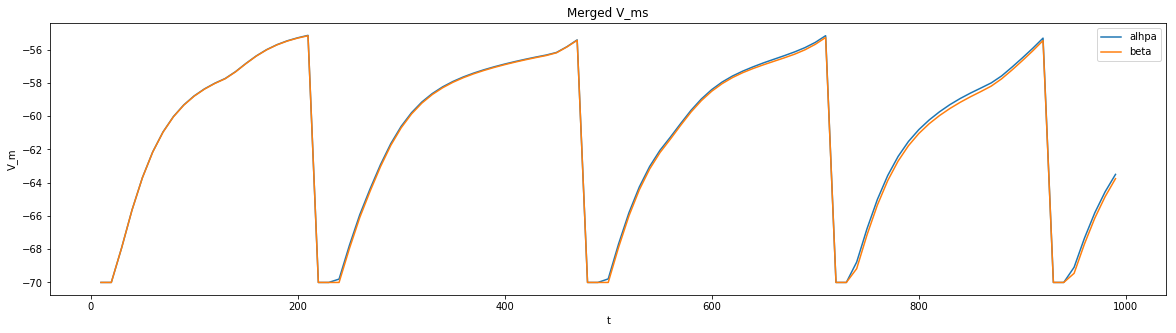

In [17]:
plot_V([m1, m2])

## Second case: Connect neurons to other populations

### Connect neurons

Each neuron also receives a synapse from 0.25% from the excitatory class of the neighboring populations.

In [18]:
opt = np.arange(inh_boundary, pop_size)
num_outer_conn = int(pop_size * outer_connectivity)
for n1,n2,n3 in zip(p1, p2, p3):
    # 4175 * 0.0025 ~ 10
    c13 = np.random.choice(opt, num_outer_conn, replace=False)
    c31 = np.random.choice(opt, num_outer_conn, replace=False)
    c23 = np.random.choice(opt, num_outer_conn, replace=False)
    c32 = np.random.choice(opt, num_outer_conn, replace=False)
     
    nest.Connect(p1[c13], n3) 
    nest.Connect(p3[c31], n1) 
    nest.Connect(p2[c23], n3) 
    nest.Connect(p3[c32], n2) 

In [19]:
nest.Simulate(t_sim)

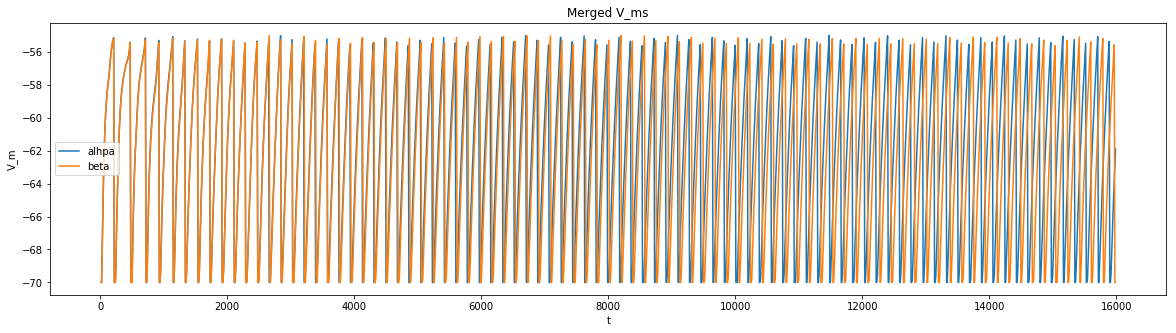

In [20]:
plot_V([m1, m2])

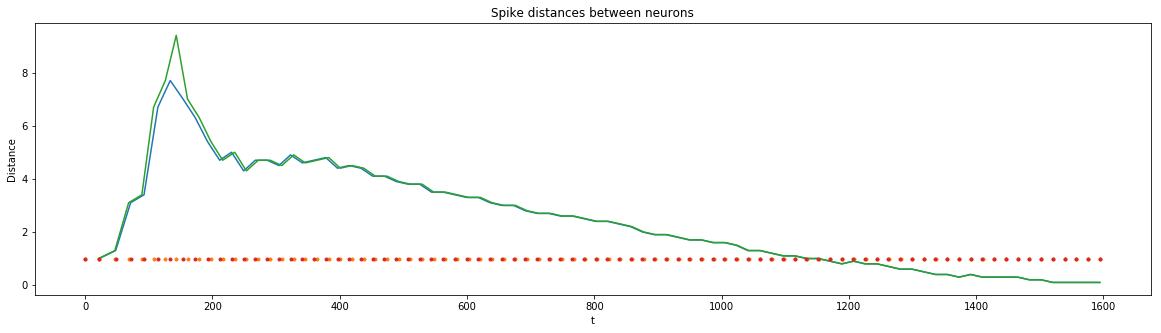

In [21]:
plot_spikes([s1, s2])

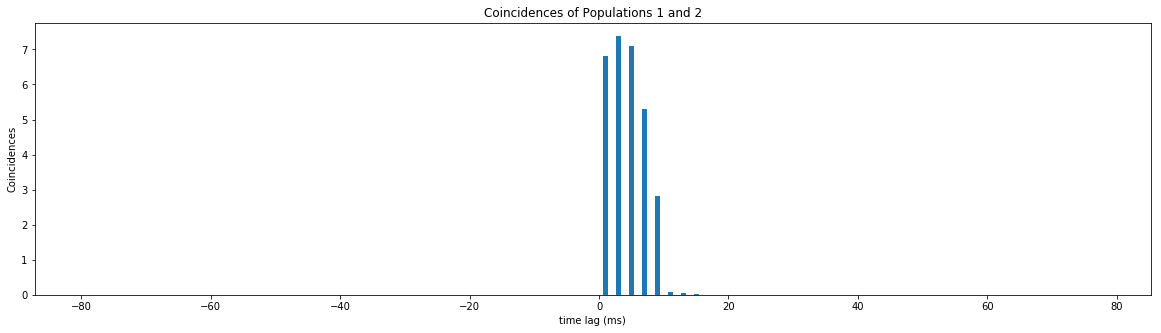

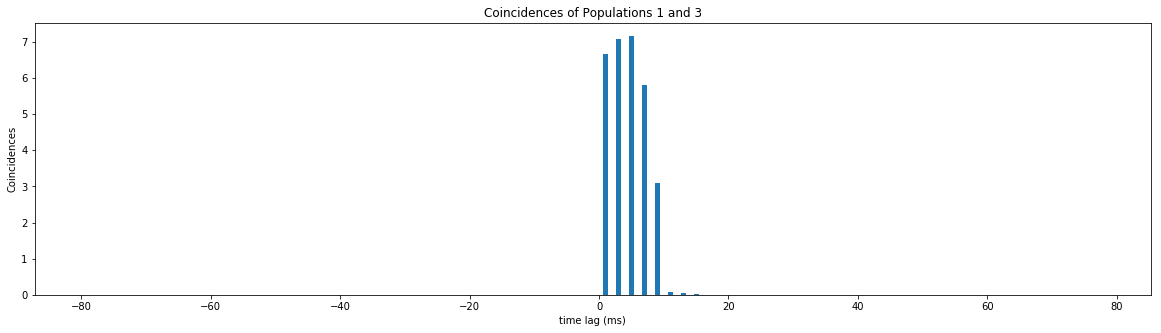

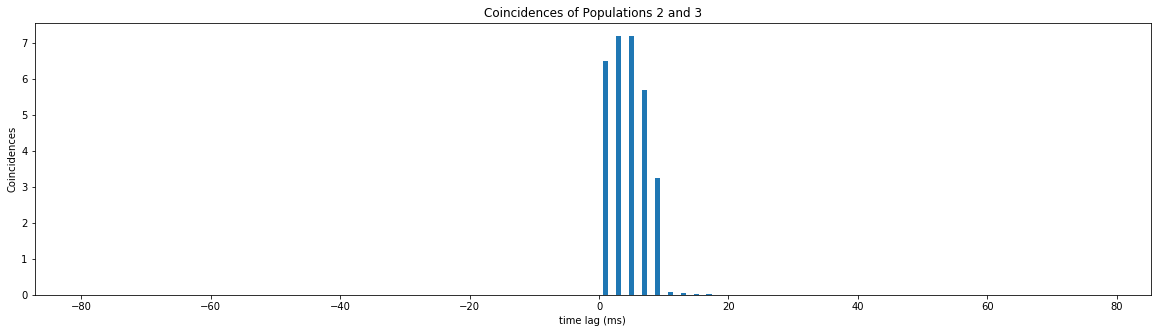

In [25]:
coinc_hists()

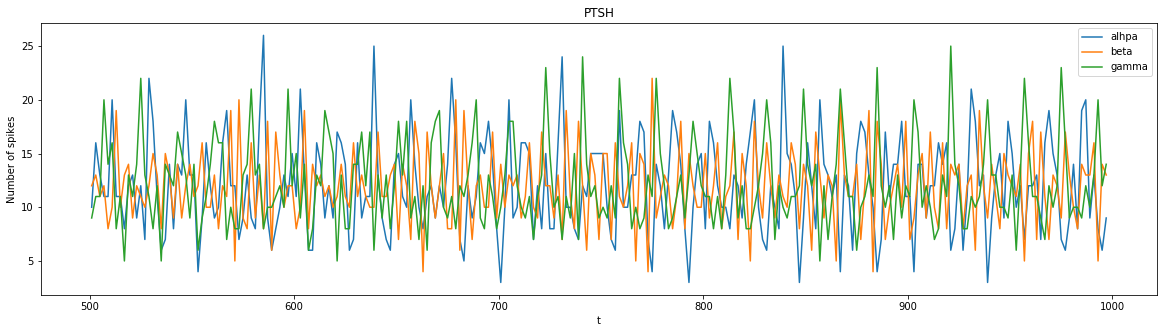

In [29]:
firing_hists()